<a href="https://colab.research.google.com/github/pachterlab/JBMMCP_2023/blob/main/notebooks/figs_f2_s1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
cat(system('python3 -c "from google.colab import drive\ndrive.mount()"', intern=TRUE), sep='\n', wait=TRUE)

Warning message in system("python3 -c \"from google.colab import drive\ndrive.mount()\"", :
“running command 'python3 -c "from google.colab import drive
drive.mount()"' had status 1”



TRUE


# Colab Setup

### Clone GitHub Repo

In [ ]:
system("git clone https://github.com/pachterlab/JBMMCP_2023.git")

### Install packages from CRAN

In [ ]:
install.packages("rjson")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



### Install Bioconductor pacakges

In [ ]:
install.packages("BiocManager", repos = "http://cran.rstudio.com/")

if (!require("BiocManager", quietly = TRUE))
    install.packages("BiocManager")

BiocManager::install("concordexR")
BiocManager::install("BiocNeighbors")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.rstudio.com

Bioconductor version 3.17 (BiocManager 1.30.21), R 4.3.0 (2023-04-21)

Installing package(s) 'BiocVersion', 'concordexR'

also installing the dependencies ‘formatR’, ‘lambda.r’, ‘futile.options’, ‘matrixStats’, ‘futile.logger’, ‘snow’, ‘BH’, ‘BiocGenerics’, ‘MatrixGenerics’, ‘S4Vectors’, ‘IRanges’, ‘S4Arrays’, ‘BiocParallel’, ‘DelayedArray’, ‘pheatmap’


Old packages: 'bit', 'broom', 'bslib', 'curl', 'devtools', 'digest', 'gargle',
  'gert', 'googledrive', 'googlesheets4', 'highr', 'isoband', 'jsonlite',
  'pkgbuild', 'pkgload', 'roxygen2', 'testthat', 'tidyverse', 'usethis',
  'vctrs', 'whisker', 'boot', 'foreign'

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package 

### Load Libraries

In [ ]:
library(rjson)
library(fs)
library(readr)
library(glue)
library(purrr)
library(dplyr)

library(ggplot2)

library(Matrix)
library(BiocNeighbors)
library(concordexR)

set.seed(1923)
data_dir <- path_wd("JBMMCP_2023/data")

### Download Data

In [ ]:
# Links to simulated matrices
sim <- fromJSON(file=path(data_dir, "simulations","sim.json"))

In [ ]:
for (i in 1:length(sim)){
  x <- sim[[i]]

  mx_args <- c(
    x$mtx_url,
    "-O", path(data_dir, "simulations",x$name, "matrix.mtx")
  )

  lbl_args <- c(
    x$label_url,
    "-O", path(data_dir, "simulations",x$name, "labels.txt")
  )

  # Download files
  system2("wget", args=lbl_args, stdout = TRUE)
  system2("wget", args=mx_args, stdout = TRUE)

}



# Analysis

Load the simulated matrices here and compute k-nearest neighbor matrix.

In [ ]:
folders <- glue("{rep(c(1000,2000,4000,8000),c(4,4,4,4))}_{rep(seq(2,8,2),4)}")

# Load all data and make master file
dirs <- glue("{path(data_dir,'simulations', folders)}")

dirs <- purrr::map(dirs, \(d) path(d, seq(1, 15, 2), "ca"))
dirs <- do.call(c, dirs)

### Compute CONCORDEX for simulated data

If Colab times out during this step, then load in the results file in the next section.

In [ ]:
for (f in folders){
    main <- f
    main_dir <- path(data_dir, "simulations", main)

    labels <- readr::read_tsv(fs::path(main_dir, "labels.txt"), col_names="assignments")
    labels <- tolower(labels$assignments)

    mtx <- readMM(path(main_dir, "matrix.mtx"))


    for (k in c(20,30,50)) {

        # generate knn matrix
        knn <- findKNN(mtx, k=k, get.distance=FALSE)
        knn <- knn$index

        knn <- as(knn, 'sparseMatrix')

        out_fn <- glue("assignments_cdx_table_{k}.csv")
        # print(out_fn)

        for (i in seq(1,15,2)){
            res_dir <- path(main_dir, i, "ca")
            out_dir <- path(main_dir, i, "ca")


            ca_labels <- read_csv(
                path(res_dir, "assignments_cellassign.csv"),
                show_col_types = FALSE)

            ca_labels <- tolower(ca_labels$cell_type)
            frac_correct <- sum(labels == ca_labels)/length(labels)

            options(show.error.messages = FALSE)
            cdx <- try(calculateConcordex(knn, ca_labels,k=k))
            main_spl <- unlist(stringr::str_split(main, "_"))

            if (class(cdx) == "try-error"){
                out <- tibble::tibble_row(
                    no_cells = as.integer(main_spl[1]),
                    no_celltypes = as.integer(main_spl[2]),
                    no_markers=i,
                    k=k,
                    frac_correct=frac_correct,
                    concordex = NA_real_,
                    mean_random_cdx = NA_real_,
                    concordex_ratio = NA_real_)

            } else {
                out <- tibble::tibble_row(
                    no_cells = as.integer(main_spl[1]),
                    no_celltypes = as.integer(main_spl[2]),
                    no_markers=i,
                    k=k,
                    frac_correct=frac_correct,
                    concordex = cdx$concordex,
                    mean_random_cdx = cdx$mean_random_concordex,
                    concordex_ratio = cdx$concordex_ratio)
            }

            write_csv(out, fs::path(out_dir, out_fn))
        }
    }
}

In [ ]:
# Useful for loading in multiple files with same column names
cn <- c("no_cells", "no_celltypes", "no_markers","k", "frac_correct",
        "concordex", "mean_random_cdx", "concordex_ratio")



cdx_data <- list.files(dirs, "*cdx_table_[235]0.csv", full.names=TRUE) %>%
  map_df(~read_csv(., col_names=TRUE))

Sometimes, Colab times out when computing CONCORDEX. This can happen while loading the matrices with 8000 cells. The file with the simulated CONCORDEX results is in the GitHub repo and can be loaded here if that happens

In [ ]:
# Uncomment this line if Colab times out while running previous step.
# cdx_data <- read_csv(path(data_dir, "simulations", "assignments_cdx_table.csv"))

In [ ]:
head(cdx_data)

In [ ]:
cdx_data <- cdx_data %>%
  mutate(frac_correct2 = round(frac_correct*100),
           k = factor(k), no_celltypes=factor(no_celltypes))

## Figure 1

In [ ]:
cdx_data %>%
    filter(no_celltypes==8, k==30) %>%
    ggplot(
        aes(concordex_ratio, frac_correct2)
        ) +
    geom_hline(
        yintercept = 50,
        linetype=2,
        color="#636363"
    ) +
    geom_vline(
        xintercept = 1,
        linetype=2,
        color="#636363"
    ) +
    geom_point() +
    labs(
        x = "Concordex Ratio",
        y = "Fraction of Correctly Assigned Cells (%)"
    ) +
    theme_bw() +
    theme(
        aspect.ratio = 1/1.5,
        panel.background=element_blank(),
        plot.background=element_blank()
    )

## Supplementary Figure 1

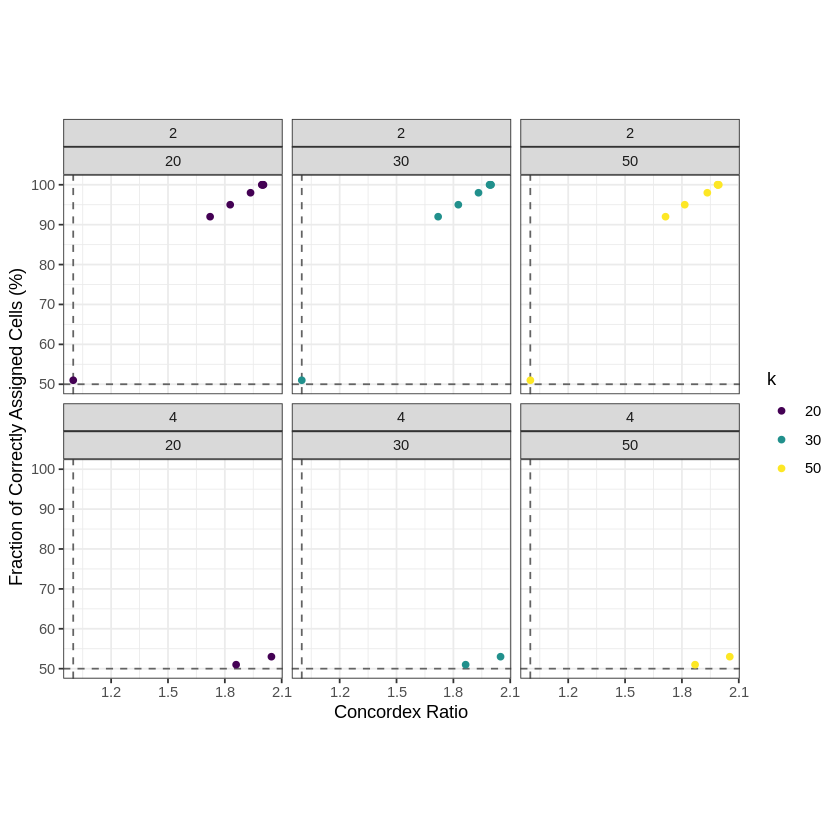

In [ ]:
fig1sup <- cdx_data %>%
    mutate(frac_correct2 = round(frac_correct*100),
           k = factor(k), no_celltypes=factor(no_celltypes)) %>%
    ggplot(
        aes(concordex_ratio, frac_correct2,color=k)) +
    geom_hline(
        yintercept = 50,
        linetype=2,
        color="#636363"
    ) +
    geom_vline(
        xintercept = 1,
        linetype=2,
        color="#636363"
    ) +
    geom_point() +
    facet_wrap(vars(no_celltypes, k),ncol = 3) +
    labs(
        x = "Concordex Ratio",
        y = "Fraction of Correctly Assigned Cells (%)"
    ) +
    theme_bw() +
    theme(
        aspect.ratio=1,
        plot.background = element_blank(),
        panel.background = element_blank()
    ) +
    scale_color_viridis_d()

  fig1sup